# Backtesting ModernBERT

Once we have fetched the data and pretrained the model, we can now turn to using the model.

---

This notebook demonstrates how to:

- **Load Model**: I have already fine-tuned models from the training output. Download them from Huggingface, or run the `prepare.py` and `torchrun` the `train.py` scripts to generate new weights.
- **Generate Signals**: Run the test dataset (Trump's Truth Social posts from H1 2025) through the fine-tuned model to get predictions `(Bullish, Bearish, Neutral)`.
- **Run VectorBT Backtest**: Use `vectorbt` to run a portfolio simulation.
    - Use the signals to generate trade entries and exits.
    - Compare the strategy's performance against the VOO price data (buy and hold benchmark).

In [11]:
import os
import io
import time
import requests
import torch

import xml.etree.ElementTree as ET
import polars as pl
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import vectorbt as vbt

from bs4 import BeautifulSoup
from datetime import date
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

trump_start = dt.datetime(2017, 1, 17)
trump_end = dt.datetime(2021, 1, 9)

csv_filename = 'truths_data_2025_h1.csv'

def fetch_truths(start_date, end_date):
    url = f"https://trumpstruth.org/feed?start_date={start_date}&end_date={end_date}"
    print(f"Fetching data for {start_date} to {end_date}...")

    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"  -> Error fetching data for this period: {e}")
        return pl.DataFrame()
    except ET.ParseError:
        print("  -> Failed to parse XML, skipping this period.")
        return pl.DataFrame()


    rss_feed = io.StringIO(response.text)
    tree = ET.parse(rss_feed)
    root = tree.getroot()

    posts = []
    for item in root.findall('./channel/item'):
        pub_date = item.find('pubDate').text
        description_html = item.find('description').text
        soup = BeautifulSoup(description_html, 'html.parser')
        text_content = soup.get_text().strip()
        posts.append({'date': pub_date, 'text': text_content})

    return pl.DataFrame(posts)

def fetch_h1():
    weekly_date_ranges = pl.date_range(start=date(2025, 1, 20), end=date(2025, 6, 30), interval='1w', eager=True)
    
    all_posts_dfs = []
    
    for start_of_week in weekly_date_ranges.to_pandas():
        end_of_week = start_of_week + pd.Timedelta(days=6)
        start_str = start_of_week.strftime('%Y-%m-%d')
        end_str = end_of_week.strftime('%Y-%m-%d')
    
        weekly_df = fetch_truths(start_str, end_str)
    
        all_posts_dfs.append(weekly_df)
    
        time.sleep(0.1)
    
    if all_posts_dfs:
        final_df = pl.concat(all_posts_dfs).with_columns(
            pl.col('date').str.to_datetime("%a, %d %b %Y %H:%M:%S %z")
        )
        final_df.write_csv(csv_filename, separator=",")
    
        print(f"\n✅ Success! Scraped {len(final_df)} posts.")
        print(f"Data saved to '{csv_filename}'.")
    else:
        print("\nNo data was fetched. The final CSV was not created.")

In [12]:
from pathlib import Path

file_path = Path(csv_filename)

if not file_path.is_file():
    fetch_h1()

schema_overrides = {
    "date": pl.Datetime,
    "text": pl.Utf8
}

# remove posts that contain no text or just http links
dataset = (
    pl.read_csv(file_path, schema_overrides=schema_overrides)
    .drop_nulls()
    .filter(
        (pl.col("text").str.strip_chars().str.len_chars() > 0) &
        (~pl.col("text").str.contains(r"^https?://[\S]+$"))
    )
)

print(f"Loaded and filtered {len(dataset)} posts.")
dataset.head()

Loaded and filtered 1329 posts.


shape: (5, 2)
┌─────────────────────┬─────────────────────────────────┐
│ date                ┆ text                            │
│ ---                 ┆ ---                             │
│ datetime[μs]        ┆ str                             │
╞═════════════════════╪═════════════════════════════════╡
│ 2025-01-26 21:19:22 ┆ RT @marklevinshowTonight on Li… │
│ 2025-01-26 20:58:10 ┆ The great Sean Hannity in the … │
│ 2025-01-26 19:05:24 ┆ Tonight on Life, Liberty & Lev… │
│ 2025-01-26 18:28:31 ┆ I was just informed that two r… │
│ 2025-01-26 01:20:39 ┆ Be sure to watch Mark Levin's … │
└─────────────────────┴─────────────────────────────────┘

In [20]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

# use ./ for local model if you trained, or use the HF downloader
model_path = "./modernbert-trump-tweet-voo-64"

model = AutoModelForSequenceClassification.from_pretrained(model_path, attn_implementation="flash_attention_2", dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(model_path)

classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    max_length=512
)

test_data_df = dataset.to_pandas()

predictions = classifier(test_data_df['text'].tolist())

test_data_df['predicted_label'] = [p['label'] for p in predictions]
test_data_df['prediction_score'] = [p['score'] for p in predictions]
test_data_df['date'] = pd.to_datetime(test_data_df['date'])
test_data_df = test_data_df.set_index('date').sort_index()

display(test_data_df.head())

Device set to use cuda:0


text  \
date                                                                     
2025-01-21 07:54:14  RT @TeamTrump🚨 President Trump signs an Execut...   
2025-01-21 07:54:19  RT @TeamTrump🚨 President Trump signs an Execut...   
2025-01-21 07:54:26  RT @TeamTrump🚨 President Trump signs an order ...   
2025-01-21 07:54:32  RT @TeamTrump🚨 President Trump signs an Execut...   
2025-01-21 07:54:41  RT @TeamTrump🚨 President Trump signs a proclam...   

                    predicted_label  prediction_score  
date                                                   
2025-01-21 07:54:14         BEARISH          0.400334  
2025-01-21 07:54:19         BEARISH          0.361764  
2025-01-21 07:54:26         BEARISH          0.428378  
2025-01-21 07:54:32         BEARISH          0.425953  
2025-01-21 07:54:41         BULLISH          0.412143

/tmp/ipykernel_90314/2839848643.py:5: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Backtest Results for H1 2025
Start                               2025-01-21 00:00:00
End                                 2025-07-07 00:00:00
Period                                115 days 00:00:00
Start Value                                   1000000.0
End Value                                1208185.448063
Total Return [%]                              20.818545
Benchmark Return [%]                           3.588362
Max Gross Exposure [%]                            100.0
Total Fees Paid                            41695.168213
Max Drawdown [%]                                4.12441
Max Drawdown Duration                  17 days 00:00:00
Total Trades                                       20.0
Total Closed Trades                                19.0
Total Open Trades                                   1.0
Open Trade PnL                             16163.767598
Win Rate [%]                                  73.684211
Best Trade [%]                                 7.195056
Worst Trade [%]    


/tmp/ipykernel_90314/2839848643.py:31: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x7ff37c7ca840>. Pass column to select a single column/group.

/home/avery/Development/presidential_alpha/.venv/lib/python3.12/site-packages/vectorbt/base/indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



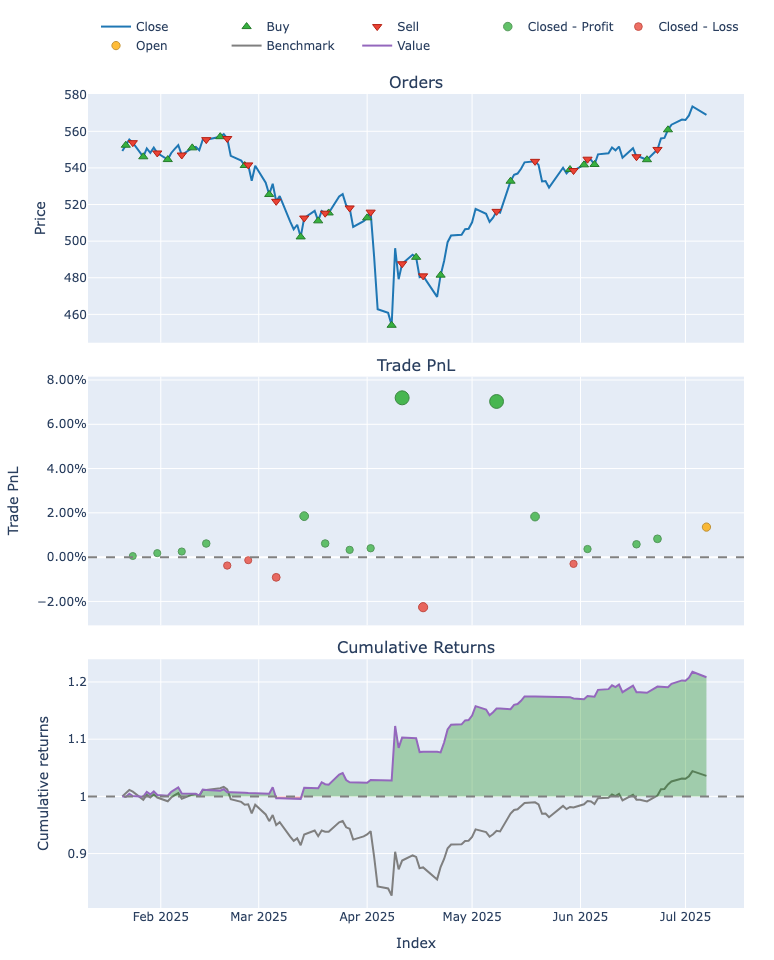

In [21]:
start_date = test_data_df.index.min().strftime('%Y-%m-%d')
end_date = (test_data_df.index.max() + dt.timedelta(days=2)).strftime('%Y-%m-%d') 

# just use the close price for now
voo_price = yf.download('VOO', start=start_date, end=end_date)['Close']

signal_map = {
    'BULLISH': 1,  # Enter
    'BEARISH': -1, # Exit
    'NEUTRAL': 0   # Hold
}
test_data_df['signal'] = test_data_df['predicted_label'].map(signal_map)

# forward-fill signals to handle non-trading days
signals = test_data_df['signal'].reindex(voo_price.index, method='ffill').fillna(0)

entries = signals == 1
exits = signals == -1

portfolio = vbt.Portfolio.from_signals(
    close=voo_price, 
    entries=entries, 
    exits=exits,
    freq='D',
    init_cash=1000000,
    fees=0.001 # 0.1% fee per trade
)

print("Backtest Results for H1 2025")
print("="*30)
print(portfolio.stats())

print("\n\nPerformance vs. Buy and Hold (VOO)")
print("="*30)
portfolio[0].plot().show()

## Let's see what the model was actually predicting


In [15]:
print("Prediction distribution:")
print(test_data_df['predicted_label'].value_counts())

print("\nBreakdown by percentage:")
print(test_data_df['predicted_label'].value_counts(normalize=True) * 100)

Prediction distribution:
predicted_label
BULLISH    520
BEARISH    435
NEUTRAL    374
Name: count, dtype: int64

Breakdown by percentage:
predicted_label
BULLISH    39.127163
BEARISH    32.731377
NEUTRAL    28.141460
Name: proportion, dtype: float64


In [41]:
import shap
from scipy.special import softmax
from IPython.display import display, HTML

def predict_proba(text_list):
    """
    Takes a list of text strings and returns the model's probabilities for each class.
    """
    # Ensure the model is in evaluation mode
    model.eval()
    
    text_list = list(text_list)
    
    # Tokenize the input texts
    inputs = tokenizer(
        text_list, 
        padding=True, 
        truncation=True, 
        max_length=8192, # Use the same max_length as in training
        return_tensors="pt"
    ).to(device)
    
    # Get model predictions without calculating gradients
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        
    # Convert logits to probabilities using softmax
    # and move the result to the CPU for NumPy conversion.
    probabilities = softmax(logits.cpu().numpy(), axis=1)
    
    return probabilities

def colorize_text(shap_explanation):
    """
    Generates and displays HTML with text highlighted by SHAP values.
    Can handle explanation objects for single or multiple sentences.
    """
    
    # Get the SHAP values and the tokens (words)
    values = shap_explanation.values
    data = shap_explanation.data

    # If the explanation is for a single sentence, the .values array will be 1D.
    # We wrap it in a list to make it 2D so the same loop works for both cases.
    if values.ndim == 1:
        values = [values]
        data = [data]
    
    # Iterate through each sentence provided in the explanation object
    for i in range(len(data)):
        sent_values = values[i]
        sent_data = data[i]
        
        # Normalize the SHAP values for this sentence to be between -1 and 1
        # We add a small epsilon to avoid division by zero
        max_abs_val = np.abs(sent_values).max() + 1e-6
        
        html_parts = []
        for token, value in zip(sent_data, sent_values):
            # Clean up the token for display (e.g., replace special space character)
            token_display = str(token).replace('Ġ', ' ')
            
            norm_val = value / max_abs_val
            
            # Set red for positive (promoting) and blue for negative (inhibiting)
            if norm_val > 0:
                color = f'rgba(255, 0, 0, {norm_val:.3f})'
            else:
                color = f'rgba(0, 0, 255, {-norm_val:.3f})'
            
            # Wrap the token in a span with the calculated background color
            html_parts.append(
                f'<span style="background-color: {color}; color: black; padding: 2px 4px; border-radius: 3px; margin: 0 1px;">{token_display}</span>'
            )

        display(HTML(" ".join(html_parts)))

explainer = shap.Explainer(predict_proba, tokenizer)
id2label = model.config.id2label

closed_trades = portfolio[0].trades.records

winning_trades = closed_trades[closed_trades['pnl'] > 0]

print(f"Found {len(winning_trades)} winning trades. Here are the posts that triggered them:\n")

for i, trade in winning_trades.iterrows():
    entry_idx_pos = int(trade['entry_idx'])
    entry_timestamp = voo_price.index[entry_idx_pos]

    exit_idx_pos = int(trade['exit_idx'])
    exit_timestamp = voo_price.index[exit_idx_pos]
    
    entry_triggers = test_data_df[test_data_df.index <= entry_timestamp]
    exit_triggers = test_data_df[test_data_df.index <= exit_timestamp]

    if not entry_triggers.empty:
        trigger_tweet = entry_triggers.iloc[-1]

        print(f"📈 Trade Profit: ${trade['pnl']:.2f}\n")
        print(f"Trade Entry Date: {entry_timestamp.strftime('%Y-%m-%d')}")
        print(f"Signal Date:      {trigger_tweet.name.strftime('%Y-%m-%d')}")
        # print(f"Trigger Text:     \"{trigger_tweet['text']}\"")
        print(f"Signal:           {trigger_tweet.predicted_label} {trigger_tweet.prediction_score}")

        shap_values = explainer([trigger_tweet['text']])
        shap_values.output_names = list(id2label.values())
        shap.plots.text(shap_values[:,:,"BULLISH"])
        colorize_text(shap_values[:, :, "BULLISH"])
        print("="*30)
        
    if not exit_triggers.empty: 
        trigger_tweet = exit_triggers.iloc[-1]
        
        print(f"Exit Date:        {exit_timestamp.strftime('%Y-%m-%d')}")
        print(f"Signal Date:      {trigger_tweet.name.strftime('%Y-%m-%d')}")
        # print(f"Trigger Text:     \"{trigger_tweet['text']}\"")
        print(f"Signal:           {trigger_tweet.predicted_label} {trigger_tweet.prediction_score}")

        shap_values = explainer([trigger_tweet['text']])
        shap_values.output_names = list(id2label.values())
        shap.plots.text(shap_values[:,:,"BEARISH"])
        colorize_text(shap_values[:,:,"BEARISH"])
        print("="*30)

Found 15 winning trades. Here are the posts that triggered them:

📈 Trade Profit: $507.70

Trade Entry Date: 2025-01-22
Signal Date:      2025-01-21
Signal:           BULLISH 0.4023200571537018


Exit Date:        2025-01-24
Signal Date:      2025-01-23
Signal:           BEARISH 0.38012921810150146


📈 Trade Profit: $1805.02

Trade Entry Date: 2025-01-27
Signal Date:      2025-01-26
Signal:           BULLISH 0.4169890880584717


Exit Date:        2025-01-31
Signal Date:      2025-01-30
Signal:           BEARISH 0.45611852407455444


📈 Trade Profit: $2546.74

Trade Entry Date: 2025-02-03
Signal Date:      2025-02-02
Signal:           BULLISH 0.37513330578804016


Exit Date:        2025-02-07
Signal Date:      2025-02-06
Signal:           BEARISH 0.40111514925956726


📈 Trade Profit: $6178.78

Trade Entry Date: 2025-02-10
Signal Date:      2025-02-09
Signal:           BULLISH 0.3546680808067322


Exit Date:        2025-02-14
Signal Date:      2025-02-13
Signal:           BEARISH 0.4304834008216858


📈 Trade Profit: $18429.86

Trade Entry Date: 2025-03-13
Signal Date:      2025-03-12
Signal:           BULLISH 0.451896071434021


Exit Date:        2025-03-14
Signal Date:      2025-03-13
Signal:           BEARISH 0.4042576551437378


📈 Trade Profit: $6258.49

Trade Entry Date: 2025-03-18
Signal Date:      2025-03-17
Signal:           BULLISH 0.40599867701530457


Exit Date:        2025-03-20
Signal Date:      2025-03-19
Signal:           BEARISH 0.36598727107048035


📈 Trade Profit: $3361.03

Trade Entry Date: 2025-03-21
Signal Date:      2025-03-20
Signal:           BULLISH 0.4736863970756531


Exit Date:        2025-03-27
Signal Date:      2025-03-26
Signal:           BEARISH 0.3521459996700287


📈 Trade Profit: $4118.78

Trade Entry Date: 2025-04-01
Signal Date:      2025-03-31
Signal:           BULLISH 0.468612402677536


Exit Date:        2025-04-02
Signal Date:      2025-04-01
Signal:           BEARISH 0.4182717502117157


📈 Trade Profit: $73950.52

Trade Entry Date: 2025-04-08
Signal Date:      2025-04-07
Signal:           BULLISH 0.4133373200893402


Exit Date:        2025-04-11
Signal Date:      2025-04-10
Signal:           BEARISH 0.3688998520374298


📈 Trade Profit: $75700.59

Trade Entry Date: 2025-04-22
Signal Date:      2025-04-21
Signal:           BULLISH 0.3763795793056488


Exit Date:        2025-05-08
Signal Date:      2025-05-07
Signal:           BEARISH 0.3818659484386444


📈 Trade Profit: $21110.76

Trade Entry Date: 2025-05-12
Signal Date:      2025-05-11
Signal:           BULLISH 0.4145263433456421


Exit Date:        2025-05-19
Signal Date:      2025-05-18
Signal:           BEARISH 0.40016189217567444


📈 Trade Profit: $4288.04

Trade Entry Date: 2025-06-02
Signal Date:      2025-06-01
Signal:           BULLISH 0.39838841557502747


Exit Date:        2025-06-03
Signal Date:      2025-06-02
Signal:           BEARISH 0.36896103620529175


📈 Trade Profit: $6819.35

Trade Entry Date: 2025-06-05
Signal Date:      2025-06-04
Signal:           BULLISH 0.4333445727825165


Exit Date:        2025-06-17
Signal Date:      2025-06-16
Signal:           BEARISH 0.34838002920150757


📈 Trade Profit: $9787.23

Trade Entry Date: 2025-06-20
Signal Date:      2025-06-19
Signal:           BULLISH 0.3803514838218689


Exit Date:        2025-06-23
Signal Date:      2025-06-22
Signal:           BEARISH 0.3896154761314392


📈 Trade Profit: $16163.77

Trade Entry Date: 2025-06-26
Signal Date:      2025-06-25
Signal:           BULLISH 0.3412075340747833


  0%|          | 0/498 [00:00<?, ?it/s]

Exit Date:        2025-07-07
Signal Date:      2025-07-06
Signal:           NEUTRAL 0.3656144440174103
